In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Download latest version
path = kagglehub.dataset_download("kaushiksuresh147/customer-segmentation")
df_test = pd.read_csv(path+'/test.csv')
df_train = pd.read_csv(path+'/train.csv')
df_train.info()
print((df_train.isnull().mean() * 100).round(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB
ID                  0.00
Gender              0.00
Ever_Married        1.74
Age                 0.00
Graduated           0.97
Profession          1.54
Work_Experience    10.28
Spending_Score      0.00
Family_Size         4.15
Var_1 

In [15]:
from scipy.spatial.distance import cdist


def Kmeans(X, k):

    # Step 1
    idx = np.random.randint(len(X)-1,size = k)#
    centroids = X[idx, :]

    
    while True:
        # Step 2
        distances = cdist(centroids,X,'euclidean')

        # Step 3
        points = np.argmin(distances, axis=0)

        # Step 4
        temp_centroids = []

        for cluster in range(k):
            # Update
            temp_cluster_centroid = X[points == cluster].mean(axis=0)
            temp_centroids.append(temp_cluster_centroid)

        temp_centroids = np.array(temp_centroids)

        # Step 5
        if ( (centroids == temp_centroids).all() ):
            # Done
            return points, centroids

        else:
            centroids = temp_centroids

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN



#ID Deleted

#Geneder OHE
#Ever_Married Inputer OHE
#Graduated Inputer OHE
#Profession Inputer OHE
#Var_1 Inputer OHE (Could be Ordinal Encoder, but don't know what the variable really indicates)

#Spending_Score Ordinal Encoder, give order

#Age Scaler
#Work_Experience Inputer Scaler
#Family_Size Inputer Scaler


drop_cols = ["ID","Segmentation"]
numeric_cols = ["Age","Work_Experience","Family_Size"]
categorical_cols = ['Gender','Ever_Married', 'Graduated', 'Profession', 'Var_1']
ordinal_cols = ["Spending_Score"]
spending_score_order = ['Low', 'Average', 'High']


numeric_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('scale',StandardScaler())
    ])

categorical_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='constant', fill_value='No')),
        ('encode', OneHotEncoder(handle_unknown='ignore',sparse_output=False)),
    ])

spending_score_pipeline = Pipeline([
        ('encoder', OrdinalEncoder(categories=[spending_score_order], handle_unknown='use_encoded_value', unknown_value=-1)),
])

preprocessor = ColumnTransformer(
    transformers = [
    ('column_dropper', 'drop', drop_cols),
    ('numeric_pipeline', numeric_pipeline, numeric_cols),
    ('categorical_pipeline', categorical_pipeline, categorical_cols),
    ('spending_score_pipeline', spending_score_pipeline, ordinal_cols),
    ],
    remainder='passthrough'
)

kmeans = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2))
])

kmeansplusplus = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2)),
    ('kmeans', KMeans(n_clusters=6, random_state=42, n_init="auto"))
])

dbscan = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2)),
    ('dbscan', DBSCAN(eps=.25, min_samples=10))
])




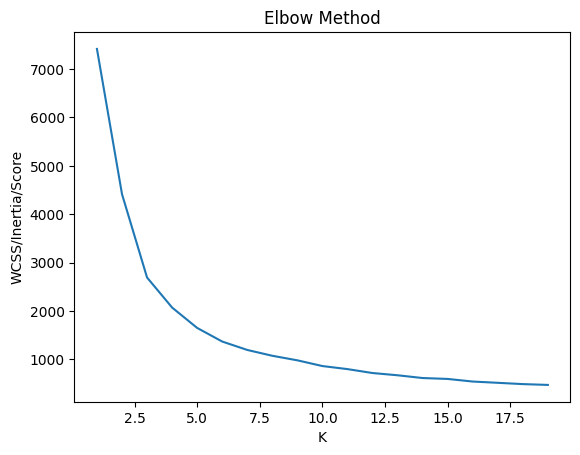

In [4]:
wcss = []

for k in range(1, 20):
    elbow = Pipeline([
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=2)),
        ('kmeans', KMeans(n_clusters=k, n_init="auto"))
    ])
    
    elbow.fit(df_test)
    wcss.append(elbow.named_steps['kmeans'].inertia_)


plt.plot(range(1, 20), wcss)
plt.title("Elbow Method")
plt.xlabel("K")
plt.ylabel("WCSS/Inertia/Score")
plt.show()

In [45]:
def plotting(model,X_pca, centers, labels):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
    try:
        plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Centroids')
    except:
        pass
    plt.title(model + ' Clustering Results')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.colorbar(scatter, label='Cluster Label')
    plt.show()


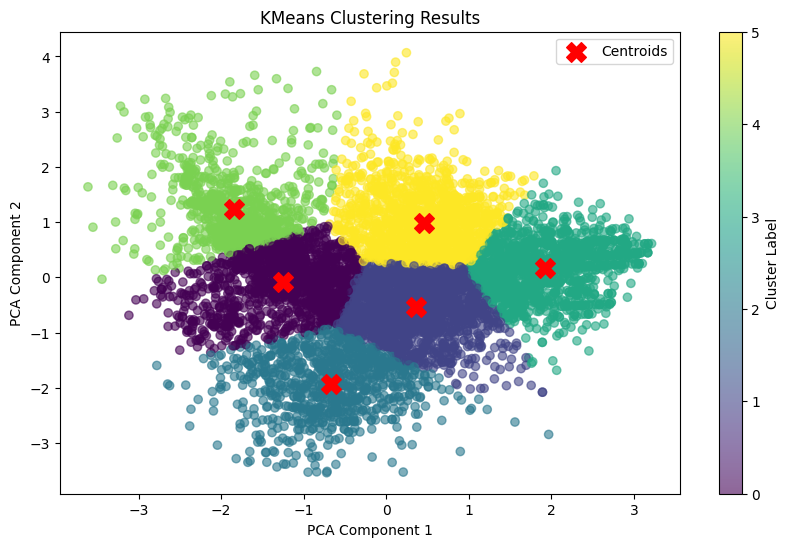

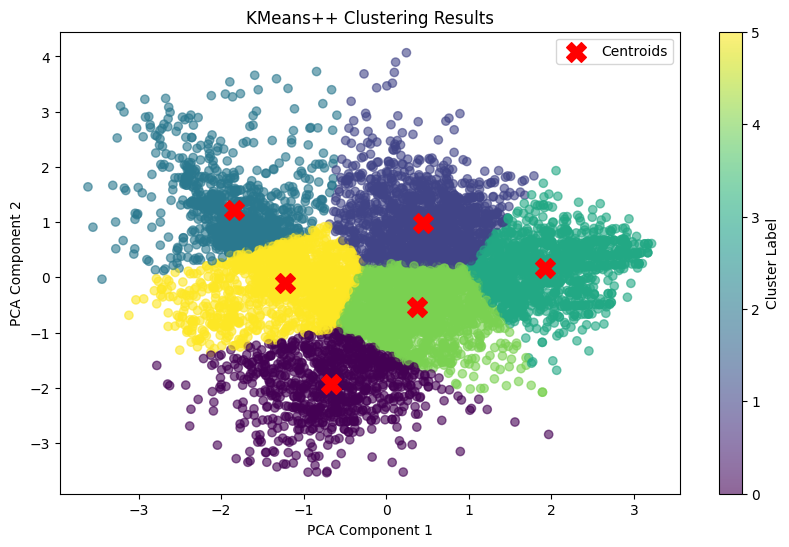

{np.int64(0), np.int64(-1)}


C:\Users\mmich\AppData\Local\Temp\ipykernel_11580\2178077532.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


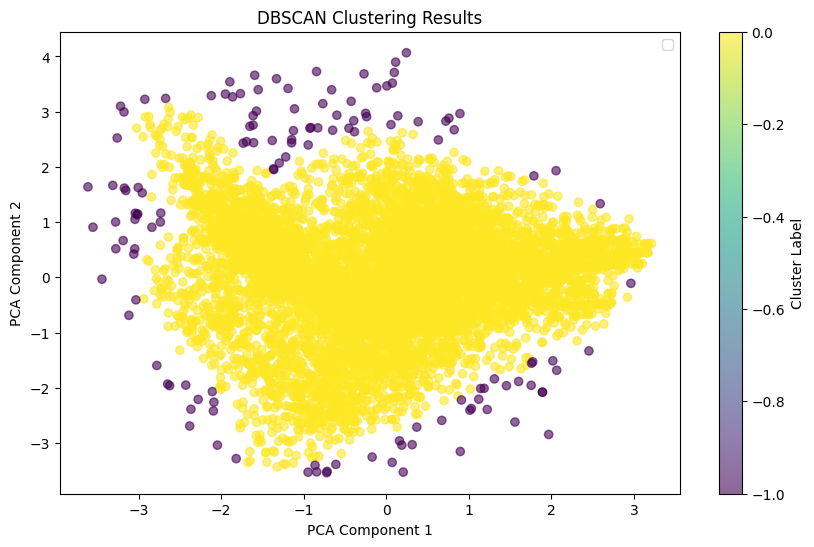

In [48]:
#Kmeans Visualization
X = kmeans.fit_transform(df_train)
points,centroids = Kmeans(X, k=6)
plotting('KMeans', X, centroids, points)

#Kmeans++ Visualization
X = kmeansplusplus.fit_transform(df_train)
labels = kmeansplusplus.named_steps['kmeans'].labels_
X_pca = kmeansplusplus.named_steps['pca'].transform(
    kmeansplusplus.named_steps['preprocessor'].transform(df_train)
)
centers = kmeansplusplus.named_steps['kmeans'].cluster_centers_
plotting('KMeans++', X_pca, centers, labels)

#DBSCAN Visualization
X = dbscan.fit(df_train)
labels = dbscan.named_steps['dbscan'].labels_
print(set(labels))
X_pca = dbscan.named_steps['pca'].transform(
    dbscan.named_steps['preprocessor'].transform(df_train)
)
plotting('DBSCAN', X_pca, None, labels)